## My research question and Corpus data

My research question is "How can bots be identified in social media comments?"

My corpus is a list of comments from Twitter/X.

I collected the first 100 comments from Donald Trump's recent tweet https://x.com/realDonaldTrump/status/1894126415932526802/photo/1 as well as got detailed information about comment authors. In addition, I got comments from the Russian media "Meduza" from the tweet https://x.com/meduzaproject/status/1894022390490837112

Comments were collected by the endpoint: https://api.twitter.com/2/tweets/search/recent

UsersInfo were collected by the endpoint: https://api.twitter.com/2/users?ids={batch_str}&user.fields=username,name,created_at,location,verified


Getting data through the Twitter API is very inconvenient if you use the free API. The available pull size for tweets and retweets is just 100 per month. My first try failed, and I reached my monthly limit. Collecting 160 retweets from 2 different tweets needed 3 different accounts from me.)))
I downloaded the data using Python because it is easier for me than R.

I still have no idea how I can detect bots and which techniques I will use. However, I found a good repository https://botometer.osome.iu.edu/bot-repository/datasets.html with different datasets, which I think will be helpful if I use supervised learning.


In [ ]:
import requests
import json
import time

In [ ]:
BEARER_TOKEN = ""

## Getting tweet comments by conversation id

In [ ]:
TWEET_ID = "1894126415932526802"
FILE_PATH = f"data/tweet_info_{TWEET_ID}.json"

def get_tweet_replies(tweet_id):
    url = "https://api.twitter.com/2/tweets/search/recent"
    headers = {"Authorization": f"Bearer {BEARER_TOKEN}"}

    all_replies = []
    next_token = None

    while True:
        params = {
            "query": f"conversation_id:{tweet_id}",
            "tweet.fields": "author_id,created_at",
            "expansions": "author_id",
            "user.fields": "username",
            "max_results": 100,
        }

        if next_token:
            params["next_token"] = next_token

        response = requests.get(url, headers=headers, params=params, timeout=10)

        if response.status_code == 200:
            data = response.json()
            with open(FILE_PATH+"_all", "w", encoding="utf-8") as file:
                json.dump(data, file, ensure_ascii=False, indent=4)
            all_replies.extend(data.get("data", []))


            next_token = data.get("meta", {}).get("next_token")
            if not next_token:
                break

        else:
            print(f"Error {response.status_code}: {response.json()}")
            break

    return all_replies

'''
tweet_replies = get_tweet_replies(TWEET_ID)


with open(FILE_PATH, "w", encoding="utf-8") as file:
    json.dump(tweet_replies, file, ensure_ascii=False, indent=4)

print(f"Data saved to {FILE_PATH}")
'''

'\ntweet_replies = get_tweet_replies(TWEET_ID)\n\n\nwith open(FILE_PATH, "w", encoding="utf-8") as file:\n    json.dump(tweet_replies, file, ensure_ascii=False, indent=4)\n\nprint(f"Data saved to {FILE_PATH}")\n'

## Get Users info by ID

In [ ]:

FILE_PATH = f"data/tweet_info_{TWEET_ID}.json"
FILE_PATH1 = f"data/user_info_{TWEET_ID}.json"
BATCH_SIZE = 100
SLEEP_TIME = 900

with open(FILE_PATH, "r", encoding="utf-8") as file:
    data = json.load(file)


users = list(set(tweet["author_id"] for tweet in data))
print(f"Total unique users: {len(users)}")


def get_users_info(user_ids):
    """Fetches user information from Twitter in batches with 15-minute wait time."""
    all_users_info = []

    for i in range(0, len(user_ids), BATCH_SIZE):
        batch = user_ids[i : i + BATCH_SIZE]
        batch_str = ",".join(batch)

        url = f"https://api.twitter.com/2/users?ids={batch_str}&user.fields=username,name,created_at,location,verified"
        headers = {"Authorization": f"Bearer {BEARER_TOKEN}"}

        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            with open(FILE_PATH1+"_all", "w", encoding="utf-8") as file:
                json.dump(response.json(), file, ensure_ascii=False, indent=4)
            all_users_info.extend(response.json().get("data", []))
        else:
            print(f"Error {response.status_code}: {response.json()}")

        if i + BATCH_SIZE < len(user_ids):
            print("Rate limit reached. Waiting 15 minutes before the next batch...")
            time.sleep(SLEEP_TIME)

    return all_users_info


users_info = get_users_info(users)


with open(FILE_PATH1, "w", encoding="utf-8") as file:
    json.dump(users_info, file, ensure_ascii=False, indent=4)

print(f"User data saved to {FILE_PATH1}")


Total unique users: 84
User data saved to data/user_info_1894126415932526802.json


In [1]:
install.packages("devtools")
install.packages("tidytext")
install.packages("plyr")
install.packages("tidyverse")
install.packages("quanteda")

# load libraries
library(devtools)
library(tidytext)
library(plyr)
library(tidyverse)
library(quanteda)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SnowballC’, ‘janeaustenr’, ‘tokenizers’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ISOcodes’, ‘fastmatch’, ‘stopwords’


Loading required package: usethis

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compa

## Basic summary statistics for Donald Trump's tweet comments

In [8]:
library(jsonlite)

json_data <- fromJSON("/content/tweet_info_1894126415932526802.json")


tweets_df <- data.frame(
  doc_id = json_data$id,
  author_id = json_data$author_id,
  created_at = json_data$created_at,
  text = json_data$text,
  stringsAsFactors = FALSE
)

Donald_Trump_tweet_corpus <- corpus(tweets_df, text_field = "text")


Donald_Trump_tweet_corpus_summary <- summary(tweet_corpus)

Donald_Trump_tweet_corpus_summary


,Text,Types,Tokens,Sentences,author_id,created_at
,<chr>,<int>,<int>,<int>,<chr>,<chr>
1,1894631283030200625,5,10,1,1452016545832443909,2025-02-26T06:11:13.000Z
2,1894631241372098904,2,2,1,1872496066467151872,2025-02-26T06:11:03.000Z
3,1894631230068367498,2,2,1,1724760344214880256,2025-02-26T06:11:00.000Z
4,1894631048916750671,10,10,1,1907995310,2025-02-26T06:10:17.000Z
5,1894631030444675487,29,32,3,2373859070,2025-02-26T06:10:12.000Z
6,1894631020865167579,41,66,3,1666156625588260864,2025-02-26T06:10:10.000Z
7,1894630956163596550,20,23,2,1065156308146548736,2025-02-26T06:09:55.000Z
8,1894630950174138713,25,26,2,1239126011247198209,2025-02-26T06:09:53.000Z
9,1894630936857514451,41,66,3,1666156625588260864,2025-02-26T06:09:50.000Z


In [10]:
DT_tweet_tokens <- tokens(Donald_Trump_tweet_corpus, remove_punct = T)
print(DT_tweet_tokens)

Tokens consisting of 99 documents and 2 docvars.
1894631283030200625 :
[1] "@realDonaldTrump"        "and"                    
[3] "this"                    "https://t.co/4R9w5U5K2a"

1894631241372098904 :
[1] "@realDonaldTrump"        "https://t.co/3vOKKbDrvA"

1894631230068367498 :
[1] "@realDonaldTrump" "Good"            

1894631048916750671 :
[1] "@realDonaldTrump" "Decentralized"    "exchanges"        "facilitate"      
[5] "direct"           "crypto"           "trading"          "without"         
[9] "intermediaries"  

1894631030444675487 :
 [1] "@realDonaldTrump" "Bully"            "Trump"            "backed"          
 [5] "into"             "a"                "corner"           "That’s"          
 [9] "what"             "usually"          "happens"          "when"            
[ ... and 14 more ]

1894631020865167579 :
 [1] "@realDonaldTrump" "🇺🇸"               "🇺🇸"               "🇺🇸"              
 [5] "🇺🇸"               "🇺🇸"               "🇺🇸"               "🇺🇸"           

In [38]:
# create a tokens object
dt_tokens <- tokens(DT_tweet_tokens,
    remove_punct=T,
    remove_numbers=T,
    remove_symbols=T)

dt_tokens <- tokens_remove(dt_tokens, stopwords("english"))
dt_tokens <- tokens_remove(dt_tokens, pattern = "^@\\w+", valuetype = "regex")

dt_dfm <- dfm(dt_tokens)

# find out a quick summary of the dfm
dt_dfm

Document-feature matrix of: 99 documents, 663 features (98.74% sparse) and 2 docvars.
                     features
docs                  https://t.co/4r9w5u5k2a https://t.co/3vokkbdrva good
  1894631283030200625                       1                       0    0
  1894631241372098904                       0                       1    0
  1894631230068367498                       0                       0    1
  1894631048916750671                       0                       0    0
  1894631030444675487                       0                       0    0
  1894631020865167579                       0                       0    0
                     features
docs                  decentralized exchanges facilitate direct crypto trading
  1894631283030200625             0         0          0      0      0       0
  1894631241372098904             0         0          0      0      0       0
  1894631230068367498             0         0          0      0      0       0
  18946310489

In [12]:
install.packages("quanteda.textplots")
library(quanteda.textplots)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘coda’, ‘extrafontdb’, ‘Rttf2pt1’, ‘statnet.common’, ‘extrafont’, ‘ggrepel’, ‘sna’, ‘igraph’, ‘network’




Warning message in text.default(x1, y1, word[i], cex = (1 + adjust) * size[i], offset = 0, :
“font metrics unknown for Unicode character U+1F1FA”
Warning message in text.default(x1, y1, word[i], cex = (1 + adjust) * size[i], offset = 0, :
“font metrics unknown for Unicode character U+1F1F8”


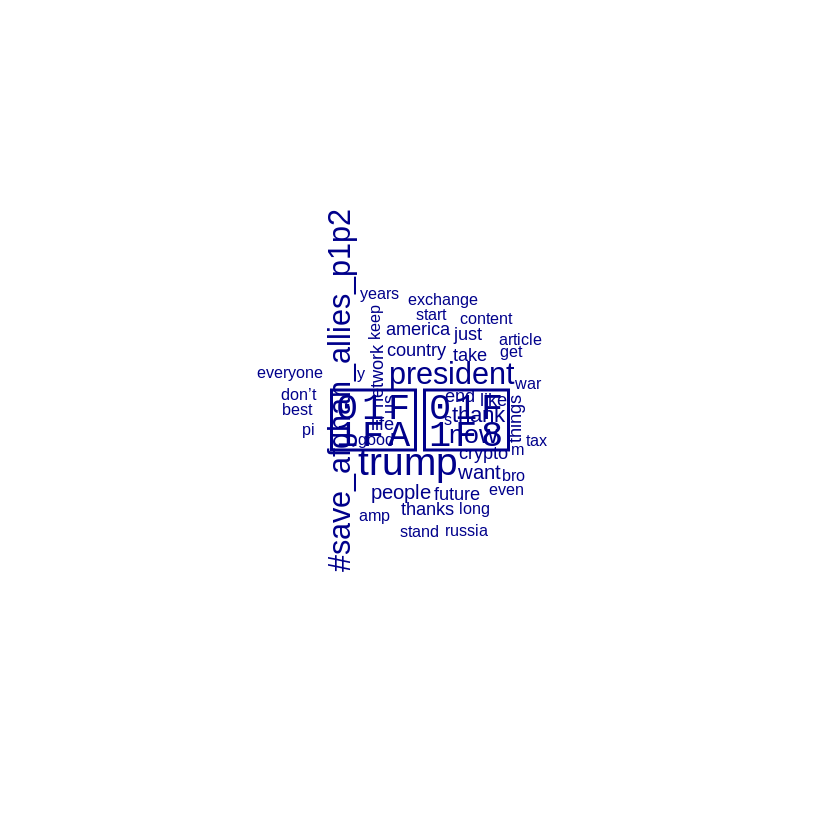

In [42]:
set.seed(1234)

textplot_wordcloud(dt_dfm, min_count = 3,  random_order = FALSE)

## Basic summary statistics for the Meduza tweet comments

In [23]:
library(jsonlite)

json_meduza_data <- fromJSON("/content/tweet_info_1894022390490837112.json")


meduza_tweets_df <- data.frame(
  doc_id = json_meduza_data$id,
  author_id = json_meduza_data$author_id,
  created_at = json_meduza_data$created_at,
  text = json_meduza_data$text,
  stringsAsFactors = FALSE
)

meduza_tweet_corpus <- corpus(meduza_tweets_df, text_field = "text")


meduza_tweet_corpus_summary <- summary(meduza_tweet_corpus)

meduza_tweet_corpus_summary


,Text,Types,Tokens,Sentences,author_id,created_at
,<chr>,<int>,<int>,<int>,<chr>,<chr>
1,1894420450970648686,14,14,1,1617370594064105472,2025-02-25T16:13:26.000Z
2,1894362710688595972,13,14,2,790486619694493697,2025-02-25T12:24:00.000Z
3,1894340449642684731,15,16,1,1064545506276315136,2025-02-25T10:55:32.000Z
4,1894340310592786589,3,3,1,1064545506276315136,2025-02-25T10:54:59.000Z
5,1894334816876675428,14,15,2,1552607512062459904,2025-02-25T10:33:10.000Z
6,1894333158071357775,10,10,1,540523554,2025-02-25T10:26:34.000Z
7,1894329343599333759,9,9,1,1731527040,2025-02-25T10:11:25.000Z
8,1894329281481785786,8,8,1,1731527040,2025-02-25T10:11:10.000Z
9,1894329154964709795,15,15,1,1731527040,2025-02-25T10:10:40.000Z


In [24]:
meduza_tweet_tokens <- tokens(meduza_tweet_corpus, remove_punct = T)
print(meduza_tweet_tokens)

Tokens consisting of 84 documents and 2 docvars.
1894420450970648686 :
 [1] "@meduzaproject" "Ну"             "так"            "потому"        
 [5] "что"            "это"            "не"             "вторжение"     
 [9] "а"              "защита"         "своих"          "новых"         
[ ... and 1 more ]

1894362710688595972 :
 [1] "@meduzaproject" "Этот"           "таймлайн"       "слишком"       
 [5] "резко"          "изменился"      "Я"              "к"             
 [9] "такому"         "не"             "был"            "готов"         

1894340449642684731 :
 [1] "@varooleg71"    "@meduzaproject" "Они"            "именно"        
 [5] "что"            "полицейские"    "такие"          "же"            
 [9] "как"            "российские"     "зазишают"       "сволочей"      

1894340310592786589 :
[1] "@meduzaproject" "Бляди"         

1894334816876675428 :
 [1] "@Papa0278528197" "@meduzaproject"  "Животное"        "вы"             
 [5] "вобще"           "никто"           "Хохл

In [32]:
# create a tokens object
meduza_tweet_tokens <- tokens(meduza_tweet_tokens,
    remove_punct=T,
    remove_numbers=T,
    remove_symbols=T)

meduza_tweet_tokens <- tokens_remove(meduza_tweet_tokens, stopwords("russian"))

meduza_tweet_tokens <- tokens_remove(meduza_tweet_tokens, pattern = "^@\\w+", valuetype = "regex")


meduza_dfm <- dfm(meduza_tweet_tokens)

# find out a quick summary of the dfm
meduza_dfm

Document-feature matrix of: 84 documents, 462 features (98.63% sparse) and 2 docvars.
                     features
docs                  это вторжение защита своих новых территорий таймлайн
  1894420450970648686   1         1      1     1     1          1        0
  1894362710688595972   0         0      0     0     0          0        1
  1894340449642684731   0         0      0     0     0          0        0
  1894340310592786589   0         0      0     0     0          0        0
  1894334816876675428   0         0      0     0     0          0        0
  1894333158071357775   0         0      0     0     0          0        0
                     features
docs                  слишком резко изменился
  1894420450970648686       0     0         0
  1894362710688595972       1     1         1
  1894340449642684731       0     0         0
  1894340310592786589       0     0         0
  1894334816876675428       0     0         0
  1894333158071357775       0     0         0
[ reach

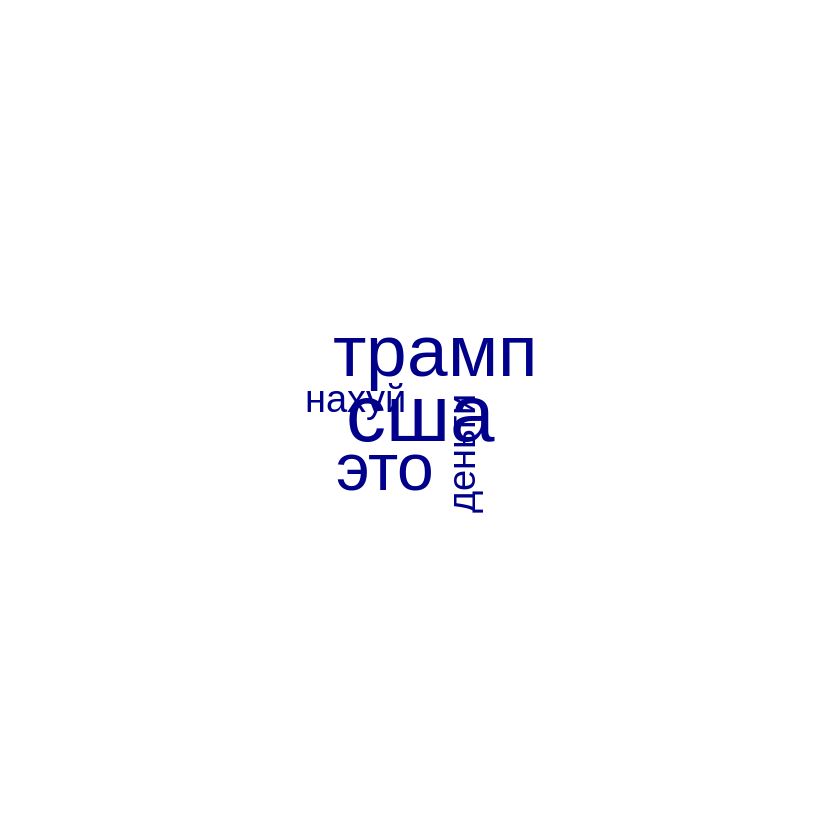

In [37]:
set.seed(12345)

textplot_wordcloud(meduza_dfm, min_count = 4, random_order = FALSE)